In [2]:
import gensim
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.test.utils import datapath
import argparse
import multiprocessing
from time import time
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import logging
import numpy as np
from gensim.models.word2vec import  PathLineSentences, LineSentence

In [3]:
folder = 'training-monolingual.tokenized.shuffled/'
short_folder = 'training-monolingual.tokenized.shuffled_short/'
words_list_file= 'liste_mots_devoir4.txt'

In [34]:
def get_args():

    parser = argparse.ArgumentParser(description="train a gensim word2vec model from text read on stdin")

    parser.add_argument("-v", '--verbosity', type=int, help="increase output verbosity", default=0)
    parser.add_argument("-n", '--nb', type=int, help="# of input lines to read", default=None)
    parser.add_argument("-d", '--datapath', type=str, help="directory where txt files can be found", default=None)
    parser.add_argument("-f", '--name', type=str, help="basename modelname", default="genw2v")
    parser.add_argument("-s", '--size', type=int, help="dim of vectors", default=300)
    parser.add_argument("-g", '--negative', type=int, help="# neg samples", default=100)
    parser.add_argument("-c", '--mincount', type=int, help="min count of a word", default=1)
    parser.add_argument("-w", '--window', type=int, help="window size", default=2)

    return parser.parse_args()

def plot(ext,times, sent_len):

    print('Creating the figure')
    

    plt.figure(figsize=(9, 6))
    plt.plot(sent_len, times, 'r--')
    plt.title("Le temps mis pour entrainer les modeles en fonction du nombre de phrases considérées")
    plt.xlabel("Nombre de phrases considérées")
    plt.ylabel("Le temps mis pour entrainer les modeles (en secondes)")
    plt.savefig(f"courbe-{ext}.svg",format="svg")
    plt.savefig(f"courbe-{ext}.png", format="png")
    plt.savefig(f"courbe-{ext}.eps", format="eps")


def similar_words(file,modelname):
    model = Word2Vec.load(modelname)
    unrecognized_words = []
    with open(file, 'r', encoding="utf8") as in_file, \
     open('out_'+file, mode='w') as out_file:
        lines = in_file.readlines()
        print(f"Looking for similar words for {len(lines)} words")
        for line in tqdm(lines):
            word = line.strip()
            try:
                liste = model.wv.most_similar(positive=[word])[:10]
                line_out = ""
                for x in liste:
                    line_out+= f"{x[0]} [{x[1]:.2f}] " 
                out_file.write(f"{word}\t{line_out}\n")
            except:
                unrecognized_words.append(word)
                print(f"The word: '{word}' is not in vocab")
    np.savetxt('unrecognized_words.txt', unrecognized_words ,delimiter ="\n", fmt ='% s')    
    in_file.close()
    out_file.close()
    
def checkpoint(ext,save_model,w2v_model,times,sizes):
    
    modelname = f"models/{ext}.w2v"
    #txt_modelname  = f"outputs/{ext}.txt"
    csv_times_sizes= f"outputs/{ext}.csv"

    if save_model:
        # stream the model
        w2v_model.init_sims(replace=True)
        w2v_model.save(modelname)
        logging.info(f"saved {modelname}")

    # this one exports a textfile that spacy can (hopefully) convert
    
    # w2v_model.wv.save_word2vec_format(txt_modelname)
    # logging.info(f"saved {txt_modelname}")
    
    np.savetxt(csv_times_sizes, [times,sizes],delimiter =", ", fmt ='% s')
    logging.info(f"saved {csv_times_sizes}")

In [5]:

def train(args,  save_model = True , data = folder,nb_tranches=10):
    # Utilisez gensim pour entrainer des representations vectorielles sur tout ou partie du 1BWC.
    #train by tranche + save the time for each tranche
    print('Starting the training 1')
    files = listdir(data)[:nb_tranches]
    sents = []
    times = []
    times_v = []
    sizes = []
    sent_len = []

    # Time to build model 
    start_time = time()
    w2v_model = Word2Vec(
        #sentences = sents,#LineSentence(datapath(training_sample)),
        #corpus_file=training_sample,
        min_count=args.mincount, window=args.window,  alpha=1e-2, vector_size=args.size,
        min_alpha=1e-4, workers=(os.cpu_count()*2 - 1), sample=0.01, negative=args.negative
        )
    end_m = round((time() - start_time),2)
    print(f"- Temps de construction de modèle (en secondes): {end_m}\n")

    for i,fn in enumerate(files):
        print(f"\n{'#-'*10}-Files 1..{i+1}:")

        start_time = time()
        sents = LineSentence(data+fn)
        print(f"- Temps de lecture de sentences (en secondes): {(time() - start_time)}\n")

        start_time = time()
        w2v_model.build_vocab(
            corpus_iterable=sents,#LineSentence(datapath(training_sample)),
            #corpus_file=training_sample, 
            progress_per=10000, update=True if i>0 else False
            )
        end_v = round((time() - start_time)/60,2)
        times_v.append(end_v)
        print(f"- Temps de construction de vocabulaire (en minutes): {end_v}\n")

        # Time to train the model
        start_time = time()
        w2v_model.train( corpus_iterable = sents,#LineSentence(datapath(training_sample)),
            #corpus_file=training_sample,
            total_examples=w2v_model.corpus_count, epochs=10, report_delay=1
                        ) 
        end = round((time() - start_time)/60,2)
        times.append(end)
        print(f"- Temps d'entrainement (en minutes): {end}\n")

        # Size of the model
        size = round(w2v_model.estimate_memory()['total']/(1024*1024),2)
        sizes.append(size)
        sent_len.append()

        print(f"- Taille du modele sur disque (en octets)): {w2v_model.estimate_memory()}\n\
                Total en MB: {size}")

        print("\n- Nombre de mots encodés (= taille du vocab): %d\n" % len(w2v_model.wv.vectors))
        #print(w2v_model.most_similar(positive=['abnormalities'], topn = 10))
        #w2v_model.init_sims(replace=True)
        print(w2v_model.wv.most_similar(positive=['abnormalities'])[:10])

    ext = "{}-size{}-window{}-neg{}-mincount{}".format(args.name, args.size, args.window, args.negative, args.mincount)

    checkpoint(ext,save_model,w2v_model,times,sizes)

    plot(ext,times, sent_len)
    similar_words(words_list_file)
    return w2v_model


In [6]:
def train2(args,  save_model = True , data = folder,nb_tranches=10):
    # Utilisez gensim pour entrainer des representations vectorielles sur tout ou partie du 1BWC.
    #train by tranche + save the time for each tranche
    print('Starting the training 2')
    files = listdir(data)[:nb_tranches]
    sents = []
    times = []
    times_v = []
    sizes = []
    sent_len = []

    for i,fn in enumerate(files):
        print(f"\n{'#-'*10}-Files 1..{i+1}:")
        with open(data + fn, 'r', encoding="utf8") as f:
            ## OLD ##
            # corpus = f.read()  # TRANCHE
            # sentences = corpus.split('\n')  #phrases in the tranche
            # sents.append(sentences) # train accumulative

            # phrases = Phrases(sents, min_count=10, progress_per=1000)
            # bigram = Phraser(phrases)
            # sents_b = bigram[sents]
            
            ## NEW ##
            sents.append(f.readlines())
            #sents_b = Phraser(Phrases(sents, min_count=1, progress_per=1000))[sents]

            # Time to build model with vocab
            start_time = time()
            w2v_model = Word2Vec(
                sentences = sents,
                #corpus_file=training_sample,
                min_count=args.mincount, window=args.window,  alpha=1e-2, vector_size=args.size,
                min_alpha=1e-4, workers=(os.cpu_count()*2 - 1), sample=0.01, negative=args.negative
                )
            end_m = round((time() - start_time)/60,2)
            print(f"- Temps de construction de modèle (en minutes): {end_m}\n")

            start_time = time()
            w2v_model.build_vocab(
                corpus_iterable=sents,
                #corpus_file=training_sample, 
                progress_per=10000,
                #update=True
                )
            end_v = round((time() - start_time)/60,2)
            times_v.append(end_v)
            print(f"- Temps de construction de vocabulaire (en minutes): {end_v}\n")

            # Time to train the model
            start_time = time()
            w2v_model.train( corpus_iterable = sents,
                #corpus_file=training_sample,
                total_examples=w2v_model.corpus_count, epochs=10, report_delay=1
                            ) 
            end = round((time() - start_time)/60,2)
            times.append(end)
            print(f"- Temps d'entrainement (en minutes): {end}\n")

            # Size of the model
            size = round(w2v_model.estimate_memory()['total']/(1024*1024),2)
            sizes.append(size)

            print(f"- Taille du modele sur disque (en octets)): {w2v_model.estimate_memory()}\n\
                    Total en MB: {size}")

            print("\n- Nombre de mots encodés (= taille du vocab): %d\n" % len(w2v_model.wv.vectors))
            w2v_model.init_sims(replace=True)
            #print(w2v_model.most_similar(positive=['abnormalities'], topn = 10))
            print(w2v_model.wv.most_similar(positive=['abnormalities'])[:10])
        f.close()
    ext = "{}-size{}-window{}-neg{}-mincount{}".format(args.name, args.size, args.window, args.negative, args.mincount)

    checkpoint(ext,save_model,w2v_model,times,sizes)

    plot(ext,times, sent_len)
    similar_words(words_list_file)
    return w2v_model



In [16]:
def get_args_notebook():
    class Args:
        def __init__(self) -> None:
            super().__init__()
            self.name, self.size, self.window, self.negative, self.mincount = "genw2v",300,2,100,1
    args = Args()
    return args
def main():
    args = get_args_notebook()
    
    ext = "{}-size{}-window{}-neg{}-mincount{}".format(args.name, args.size, args.window, args.negative, args.mincount)

    logname  = f"outputs/{ext}.log"

    # logging.basicConfig(#filename=logname,
    #                     format="%(levelname)s %(asctime)s  %(message)s",
    #                     datefmt= '%H:%M:%S', level=logging.INFO,
    #                     handlers=[
    #                         logging.FileHandler(logname),  logging.StreamHandler()
    #                     ])
    logging.basicConfig(filename=logname,datefmt= '%H:%M:%S', format='%(message)s', level=logging.DEBUG)

    

    train2(args, data = folder,nb_tranches=10)  # remove the data argument for all tranches

if __name__ == '__main__':
    main()

Starting the training 2

#-#-#-#-#-#-#-#-#-#--Files 1..1:
- Temps de construction de modèle (en minutes): 0.31

- Temps de construction de vocabulaire (en minutes): 0.09

- Temps d'entrainement (en minutes): 0.95

- Taille du modele sur disque (en octets)): {'vocab': 153027000, 'vectors': 367264800, 'syn1neg': 367264800, 'total': 887556600}
                    Total en MB: 846.44

- Nombre de mots encodés (= taille du vocab): 306054



<ipython-input-6-6f01e878b1d8>:68: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


KeyError: "Key 'abnormalities' not present"

In [53]:
args = get_args_notebook()
save_model = True 
data = folder
nb_tranches=10
# Utilisez gensim pour entrainer des representations vectorielles sur tout ou partie du 1BWC.
#train by tranche + save the time for each tranche
print('Starting the training 2')
files = listdir(data)[:nb_tranches]
sents = []
times = []
times_v = []
sizes = []
sent_len = []
i,fn = 0,files[0]
#for i,fn in enumerate(files):
print(f"\n{'#-'*10}-Files 1..{i+1}:")
with open(data + fn, 'r', encoding="utf8") as f:
    ## OLD ##
    corpus = f.read()  # TRANCHE
    sentences = corpus.split('\n')  #phrases in the tranche
    sents.append(sentences) # train accumulative
    print(len(sentences))
    

    # phrases = Phrases(sents, min_count=10, progress_per=1000)
    # bigram = Phraser(phrases)
    # sents_b = bigram[sents]
    
    ## NEW ##
    
    sents= LineSentence(f) #.append(f.read().split('\n'))
    phrases = Phrases(sents, min_count=10, progress_per=1000)
    bigram = Phraser(phrases)
    sents_b = bigram[sents]
    # sents_b = Phraser(Phrases(sents, min_count=10, progress_per=1000))[sents]
    print(f"Phrases found  {len(phrases.vocab)} phrases")
    sent_len.append(len(phrases.vocab))

    # Time to build model with vocab
    start_time = time()
    w2v_model = Word2Vec(
        #sentences = sents_b,
        #corpus_file=training_sample,
        min_count=args.mincount, window=args.window,  alpha=0.03, vector_size=args.size,
        min_alpha=0.0007, workers=(os.cpu_count()*2 - 1), sample=6e-5, negative=args.negative
        )
    end_m = round((time() - start_time)/60,2)
    print(f"- Temps de construction de modèle (en minutes): {end_m}\n")

    start_time = time()
    w2v_model.build_vocab(
        corpus_iterable=sents_b,
        #corpus_file=training_sample, 
        progress_per=10000,
        #update=True
        )
    end_v = round((time() - start_time)/60,2)
    times_v.append(end_v)
    print(f"- Temps de construction de vocabulaire (en minutes): {end_v}\n")

    # Time to train the model
    start_time = time()
    w2v_model.train( corpus_iterable = sents_b,
        #corpus_file=training_sample,
        total_examples=w2v_model.corpus_count, epochs=10, report_delay=1
                    ) 
    end = round((time() - start_time)/60,2)
    times.append(end)
    print(f"- Temps d'entrainement (en minutes): {end}\n")

    # Size of the model
    size = round(w2v_model.estimate_memory()['total']/(1024*1024),2)
    sizes.append(size)

    print(f"- Taille du modele sur disque (en octets)): {w2v_model.estimate_memory()}\n\
            Total en MB: {size}")

    print("\n- Nombre de mots encodés (= taille du vocab): %d\n" % len(w2v_model.wv.vectors))
    w2v_model.init_sims(replace=True)
    #print(w2v_model.most_similar(positive=['abnormalities'], topn = 10))
    #print(w2v_model.wv.most_similar(positive=['abnormalities'])[:10])
f.close()
ext = "{}-size{}-window{}-neg{}-mincount{}".format(args.name, args.size, args.window, args.negative, args.mincount)

checkpoint(ext,save_model,w2v_model,times,sizes)
sent_len = [len(s) for s in sents]
plot(ext,times, sent_len)
similar_words(words_list_file,modelname=f"models/{ext}.w2v")



Starting the training 2

#-#-#-#-#-#-#-#-#-#--Files 1..1:
306069


KeyboardInterrupt: 

In [51]:
similar_words(words_list_file,modelname=f"models/{ext}.w2v")


  6%|▌         | 9/150 [00:00<00:01, 88.24it/s]

Looking for similar words for 150 words
The word: 'accrington' is not in vocab
The word: 'adkins' is not in vocab
The word: 'ahmadi' is not in vocab
The word: 'ainslie' is not in vocab
The word: 'alfredsson' is not in vocab
The word: 'allianz' is not in vocab


 34%|███▍      | 51/150 [00:00<00:00, 127.18it/s]

The word: 'amelie' is not in vocab
The word: 'ampatuan' is not in vocab
The word: 'anatoly' is not in vocab
The word: 'anglicans' is not in vocab
The word: 'angolan' is not in vocab
The word: 'annenberg' is not in vocab
The word: 'arturo' is not in vocab
The word: 'asher' is not in vocab
The word: 'ashfaq' is not in vocab
The word: 'ashford' is not in vocab


 43%|████▎     | 64/150 [00:00<00:00, 113.47it/s]

The word: 'christopher' is not in vocab
The word: 'lebanon' is not in vocab
The word: 'recalled' is not in vocab
The word: 'darfur' is not in vocab


 59%|█████▊    | 88/150 [00:00<00:00, 105.07it/s]

The word: 'sunni' is not in vocab
The word: 'tennessee' is not in vocab
The word: 'carlos' is not in vocab
The word: 'brazilian' is not in vocab


100%|██████████| 150/150 [00:01<00:00, 93.81it/s]


Starting the training 1
- Temps de construction de modèle (en secondes): 0.04


#-#-#-#-#-#-#-#-#-#--Files 1..1:
- Temps de lecture de sentences (en secondes): 0.0

- Temps de construction de vocabulaire (en minutes): 0.09

- Temps d'entrainement (en minutes): 4.38

- Taille du modele sur disque (en octets)): {'vocab': 95855000, 'vectors': 230052000, 'syn1neg': 230052000, 'total': 555959000}
        Total en MB: 530.2

- Nombre de mots encodés (= taille du vocab): 191710

[('Corsa', 0.9943662285804749), ('outlying', 0.9939518570899963), ('Jamaicans', 0.9936259388923645), ('Schlegel', 0.9935262203216553), ('Orla', 0.9934742450714111), ('advancements', 0.9933976531028748), ('swabbed', 0.9933505654335022), ('excitement.', 0.9927796125411987), ('Wharrie', 0.9927717447280884), ('fides', 0.9927417039871216)]


<ipython-input-34-50cfac195534>:61: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


Creating the figure


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

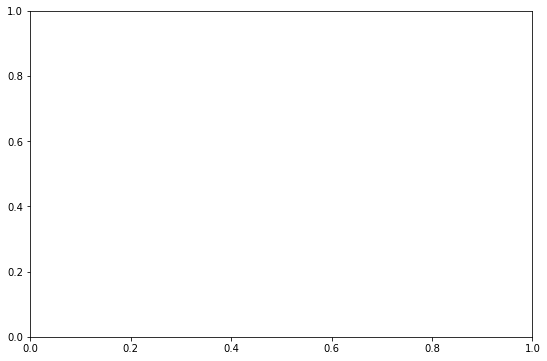

In [42]:

# Utilisez gensim pour entrainer des representations vectorielles sur tout ou partie du 1BWC.
#train by tranche + save the time for each tranche
print('Starting the training 1')
files = listdir(data)[:nb_tranches]
sents = []
times = []
times_v = []
sizes = []
sent_len = []

# Time to build model 
start_time = time()
w2v_model = Word2Vec(
    sentences = sents,#LineSentence(datapath(training_sample)),
    #corpus_file=training_sample,
    min_count=args.mincount, window=args.window,  alpha=1e-2, vector_size=args.size,
    min_alpha=1e-4, workers=(os.cpu_count()*2 - 1), sample=0.01, negative=args.negative
    )
end_m = round((time() - start_time),2)
print(f"- Temps de construction de modèle (en secondes): {end_m}\n")

#for i,fn in enumerate(files):
i,fn = 0,files[0]
print(f"\n{'#-'*10}-Files 1..{i+1}:")

start_time = time()
sents = LineSentence(data+fn)
print(f"- Temps de lecture de sentences (en secondes): {(time() - start_time)}\n")

start_time = time()
w2v_model.build_vocab(
    corpus_iterable=sents,#LineSentence(datapath(training_sample)),
    #corpus_file=training_sample, 
    progress_per=10000, update=True if i>0 else False
    )
end_v = round((time() - start_time)/60,2)
times_v.append(end_v)
print(f"- Temps de construction de vocabulaire (en minutes): {end_v}\n")

# Time to train the model
start_time = time()
w2v_model.train( corpus_iterable = sents,#LineSentence(datapath(training_sample)),
    #corpus_file=training_sample,
    total_examples=w2v_model.corpus_count, epochs=5, report_delay=1
                ) 
end = round((time() - start_time)/60,2)
times.append(end)
print(f"- Temps d'entrainement (en minutes): {end}\n")

# Size of the model
size = round(w2v_model.estimate_memory()['total']/(1024*1024),2)
sizes.append(size)

print(f"- Taille du modele sur disque (en octets)): {w2v_model.estimate_memory()}\n\
        Total en MB: {size}")

print("\n- Nombre de mots encodés (= taille du vocab): %d\n" % len(w2v_model.wv.vectors))
#print(w2v_model.most_similar(positive=['abnormalities'], topn = 10))
#w2v_model.init_sims(replace=True)
print(w2v_model.wv.most_similar(positive=['abnormalities'])[:10])

ext = "{}-size{}-window{}-neg{}-mincount{}".format(args.name, args.size, args.window, args.negative, args.mincount)

checkpoint(ext,save_model,w2v_model,times,sizes)

plot(ext,times, sent_len)


In [43]:
len(sents)

TypeError: object of type 'LineSentence' has no len()

<generator object <genexpr> at 0x000002281427EBA0>


TypeError: 'LineSentence' object is not subscriptable